<a href="https://colab.research.google.com/github/elenek97/TMA4900/blob/main/Model_with_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Forecast time series using SARIMA

In [176]:
! pip install --quiet pmdarima
! pip install impyute

In [177]:
%matplotlib inline
from pylab import rcParams
import statsmodels.api as sm
import matplotlib
import pmdarima as pm
from pmdarima import auto_arima
import statsmodels
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from IPython.display import clear_output
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
import random

In [178]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Electricity dataset

In [179]:
df1 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/AEP_hourly.csv").drop(['Datetime'], axis=1)
df2 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/NI_hourly.csv").drop(['Datetime'], axis=1)
df3 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/COMED_hourly.csv").drop(['Datetime'], axis=1)
df4 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/DAYTON_hourly.csv").drop(['Datetime'], axis=1)
df5 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/DEOK_hourly.csv").drop(['Datetime'], axis=1)
df6 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/DOM_hourly.csv").drop(['Datetime'], axis=1)
df7 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/DUQ_hourly.csv").drop(['Datetime'], axis=1)
df8 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/EKPC_hourly.csv").drop(['Datetime'], axis=1)
df9 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/FE_hourly.csv").drop(['Datetime'], axis=1)
df10 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/PJME_hourly.csv").drop(['Datetime'], axis=1)

# Sarima dataset

In [180]:
sarima=pd.read_csv("/content/gdrive/MyDrive/Master/differentsarimasimulations.csv")

In [181]:
sarima = sarima.drop('Unnamed: 0', axis=1)

In [182]:
columns = train_data.columns

## Missing value simulation

In [184]:
import scipy
import impyute

def simulate_missing(data, missing_rate):
  columns=data.columns
  miss_data = []
  for i in range(len(columns)):
    expand = missing_rate * np.ones(len(data[columns[i]]))
    mask = np.random.binomial(n=1, p=expand, size=len(expand))
    remove = 1. - mask
    miss_x = remove * data[columns[i]]
    for j in range(len(mask)):
      if mask[j]==1:
        miss_x[j]=np.nan
    miss_data.append(miss_x)
  return np.array(miss_data)

In [187]:
random.seed(1)
#decide amountof missing values
missing_ratio=0.5
sim = simulate_missing(sarima, missing_ratio)
#LOCF imputation
impute_missing = impyute.locf(sim)
df = pd.DataFrame(impute_missing)
df.columns=sarima.columns

In [188]:
df.isnull().sum().sum()

0

## forecast and model selection

In [190]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random

def SARIMAmodel(data):
  columns=data.columns
  predictions = [] #store prediction for each time series
  for i in range(len(columns)): #for each time series
    forecast_index = 45 #first index to predict
    #find model
    best_model = pm.auto_arima(data[columns[i]], test='adf', stepwise=True, seasonal=True)
    #print(best_model.summary())
    #forecast
    ts_forecast = [] #predictions for one time series
    for timestep in range(forecast_index,len(data[columns[i]])):
      best_model.fit(data[columns[i]][:timestep]) 
      preds = best_model.predict(n_periods=1) #one step ahead forecast
      ts_forecast.append(preds)

    predictions.append(ts_forecast)
    
  return predictions

In [191]:
sarima_0 = SARIMAmodel(df)

In [192]:
test_data = sarima[-5:] #last five values
test_data_noindex = test_data.reset_index()
test_data=test_data_noindex.drop(['index'], axis=1)
test_data_flattened = []
for i in range(len(columns)):
  test_data_flattened.append(test_data[columns[i]].tolist())
  #flatten to plot
test_data_flattened = sum(test_data_flattened,[])
sarima_0_flat = sum(sarima_0, [])


In [193]:
#calculate mse
mse = sklearn.metrics.mean_squared_error( np.array(test_data_flattened),np.array(sarima_0_flat))
print(mse)

303956.1720163988


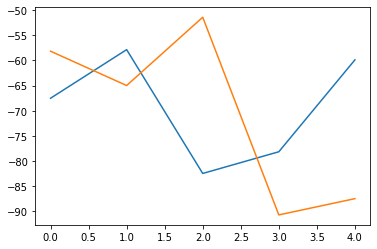

In [194]:
#plot predictions
plt.figure()
plt.plot(test_data_flattened[:5])
plt.plot(sarima_0_flat[:5])

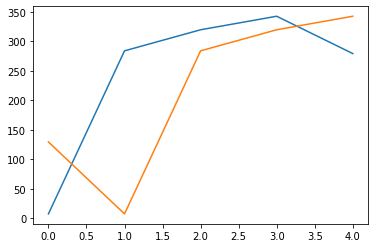

In [195]:
#plot predictions
plt.figure()
plt.plot(test_data_flattened[-5:])
plt.plot(sarima_0_flat[-5:])

### Results after running the program for the missing ratios listed in missing_ratios

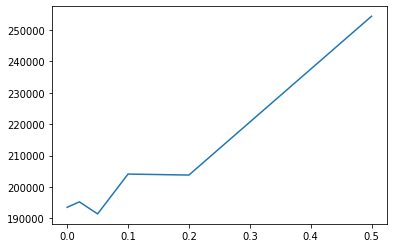

In [196]:
missing_ratios = [0, 0.02, 0.05, 0.1, 0.2, 0.5]
mses = [193530.85546402706, 195273.84447129458, 191427.73312534904, 204116.69457762703, 203803.37006157375, 254375.2050154003]
plt.plot(missing_ratios, mses)